In [2]:
import platform
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.io

if platform.system() == "Windows":

    DATA_DIR = r"E:\Programming\Machine Learning Projects\Handwritten Letter and Digit Generator\EMNIST-DATASET\emnist-byclass.mat"
else:
    DATA_DIR = "./EMNIST_data"

BATCH_SIZE = 128
LATENT_DIM = 100
EPOCHS = 50     
BUFFER_SIZE = 60000
NUM_CLASSES = 62

OUTPUT_DIR = "generated_images"
os.makedirs(OUTPUT_DIR, exist_ok=True)
log_dir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
summary_writer = tf.summary.create_file_writer(log_dir)
print("TensorBoard log directory:", log_dir)
print("Dataset will be downloaded to:", DATA_DIR)

TensorBoard log directory: logs/20250912-203906
Dataset will be downloaded to: ./EMNIST_data


I0000 00:00:1757689747.395917     354 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5527 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
import numpy as np
import scipy.io
import tensorflow as tf


MAT_FILE_PATH = r"/mnt/e/Programming/Machine Learning Projects/Handwritten Letter and Digit Generator/EMNIST-DATASET/emnist-byclass.mat"
mat = scipy.io.loadmat(MAT_FILE_PATH)

print("Top-level keys in .mat file:", mat.keys())
data = mat['dataset']

train_images = data['train'][0,0]['images'][0,0]
train_labels = data['train'][0,0]['labels'][0,0]

print("Original train_images shape:", train_images.shape)
print("Original train_labels shape:", train_labels.shape)

# Preprocess images: convert to float32, scale to [-1,1] and reshape to (28,28,1)
train_images = train_images.astype(np.float32)
train_images = (train_images / 127.5) - 1.0
train_images = train_images.reshape(-1, 28, 28, 1)

# Squeeze labels to remove extra dimensions.
train_labels = np.squeeze(train_labels)

# Defining number of classes for EMNIST byclass.
NUM_CLASSES = 62
BATCH_SIZE = 128

# Creating a tf.data.Dataset from the arrays and mapping labels to one-hot vectors.
ds_train = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
ds_train = ds_train.map(
    lambda img, lbl: (img, tf.one_hot(lbl, depth=NUM_CLASSES)),
    num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.shuffle(buffer_size=60000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# For verification:
for images_batch, labels_batch in ds_train.take(1):
    print("Images batch shape:", images_batch.shape)  
    print("Labels batch shape:", labels_batch.shape)    

Top-level keys in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'dataset'])
Original train_images shape: (697932, 784)
Original train_labels shape: (697932, 1)
Images batch shape: (128, 28, 28, 1)
Labels batch shape: (128, 62)


2025-09-12 20:39:31.894710: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
from tensorflow.keras import layers, Model

LATENT_DIM = 100

def build_generator():
    noise_input = layers.Input(shape=(LATENT_DIM,), name='noise_input')
    label_input = layers.Input(shape=(NUM_CLASSES,), name='label_input')
    merged = layers.Concatenate(axis=1)([noise_input, label_input])
    x = layers.Dense(7 * 7 * 256, use_bias=False)(merged)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 256))(x)

    x = layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    output = layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh')(x)

    model = Model([noise_input, label_input], output, name='generator')
    return model

def build_discriminator():
    image_input = layers.Input(shape=(28, 28, 1), name='image_input')
    label_input = layers.Input(shape=(NUM_CLASSES,), name='label_input')
    label_projection = layers.Dense(28*28, use_bias=False)(label_input)
    label_projection = layers.Reshape((28, 28, 1))(label_projection)
    merged = layers.Concatenate(axis=-1)([image_input, label_projection])
    x = layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(merged)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    output = layers.Dense(1)(x)
    model = Model([image_input, label_input], output, name='discriminator')
    return model

generator = build_generator()
discriminator = build_discriminator()

generator.summary()
discriminator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ noise_input         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 62)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 162)       │          0 │ noise_input[0][0… │
│ (Concatenate)       │                   │            │ label_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 12544)     │  2,032,128 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 12544)     │     50,176 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 12544)     │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 7, 7, 256) │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 7, 7, 128) │    819,200 │ reshape[0][0]     │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 14, 14,    │    204,800 │ leaky_re_lu_1[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 28, 28, 1) │      1,600 │ leaky_re_lu_2[0]… │
│ (Conv2DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,108,672 (11.86 MB)

 Trainable params: 3,083,200 (11.76 MB)

 Non-trainable params: 25,472 (99.50 KB)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 62)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 784)       │     48,608 │ label_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 28, 28, 1) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 28, 28, 2) │          0 │ image_input[0][0… │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │      3,264 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 14, 14,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 14, 14,    │          0 │ leaky_re_lu_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 128) │    204,928 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 7, 7, 128) │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 7, 7, 128) │          0 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6272)      │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      6,273 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 263,073 (1.00 MB)

 Trainable params: 263,073 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

E0000 00:00:1757689809.929579     354 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-12 20:40:10.647303: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
E0000 00:00:1757689872.612872     354 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-12 20:41:13.053101: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/50 - Gen Loss: 1.0146 - Disc Loss: 1.1396 - Time: 65.26 sec
Epoch 2/50 - Gen Loss: 1.1294 - Disc Loss: 1.0999 - Time: 58.00 sec


2025-09-12 20:43:11.936162: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3/50 - Gen Loss: 1.0844 - Disc Loss: 1.1267 - Time: 60.88 sec
Epoch 4/50 - Gen Loss: 1.0270 - Disc Loss: 1.1625 - Time: 60.17 sec
Epoch 5/50 - Gen Loss: 1.0118 - Disc Loss: 1.1795 - Time: 60.10 sec


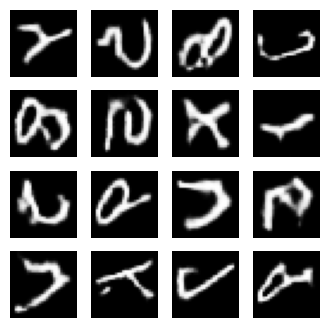

Epoch 6/50 - Gen Loss: 0.9868 - Disc Loss: 1.1882 - Time: 62.40 sec


2025-09-12 20:47:15.313586: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7/50 - Gen Loss: 0.9933 - Disc Loss: 1.1874 - Time: 60.40 sec
Epoch 8/50 - Gen Loss: 0.9976 - Disc Loss: 1.1868 - Time: 60.94 sec
Epoch 9/50 - Gen Loss: 1.0036 - Disc Loss: 1.1861 - Time: 59.15 sec
Epoch 10/50 - Gen Loss: 1.0082 - Disc Loss: 1.1825 - Time: 61.88 sec


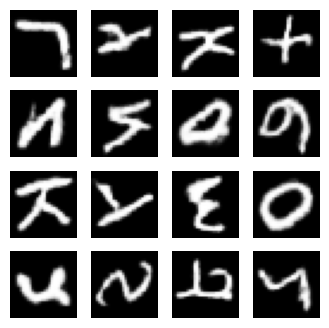

Epoch 11/50 - Gen Loss: 1.0157 - Disc Loss: 1.1795 - Time: 62.64 sec
Epoch 12/50 - Gen Loss: 1.0257 - Disc Loss: 1.1806 - Time: 62.62 sec
Epoch 13/50 - Gen Loss: 1.0236 - Disc Loss: 1.1840 - Time: 61.99 sec
Epoch 14/50 - Gen Loss: 1.0261 - Disc Loss: 1.1807 - Time: 60.67 sec
Epoch 15/50 - Gen Loss: 1.0228 - Disc Loss: 1.1814 - Time: 59.48 sec


2025-09-12 20:55:25.209436: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


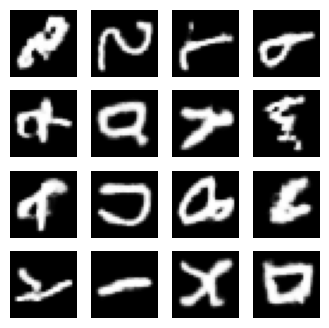

Epoch 16/50 - Gen Loss: 1.0242 - Disc Loss: 1.1766 - Time: 61.08 sec
Epoch 17/50 - Gen Loss: 1.0346 - Disc Loss: 1.1732 - Time: 59.30 sec
Epoch 18/50 - Gen Loss: 1.0341 - Disc Loss: 1.1755 - Time: 59.36 sec
Epoch 19/50 - Gen Loss: 1.0391 - Disc Loss: 1.1691 - Time: 62.45 sec
Epoch 20/50 - Gen Loss: 1.0481 - Disc Loss: 1.1668 - Time: 59.44 sec


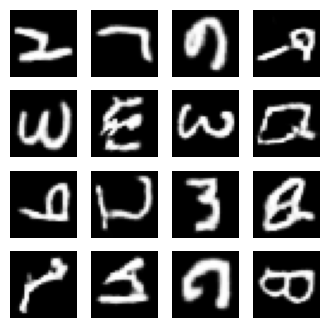

Epoch 21/50 - Gen Loss: 1.0547 - Disc Loss: 1.1661 - Time: 59.03 sec
Epoch 22/50 - Gen Loss: 1.0612 - Disc Loss: 1.1653 - Time: 67.38 sec
Epoch 23/50 - Gen Loss: 1.0536 - Disc Loss: 1.1714 - Time: 65.01 sec
Epoch 24/50 - Gen Loss: 1.0483 - Disc Loss: 1.1711 - Time: 59.09 sec
Epoch 25/50 - Gen Loss: 1.0413 - Disc Loss: 1.1792 - Time: 59.92 sec


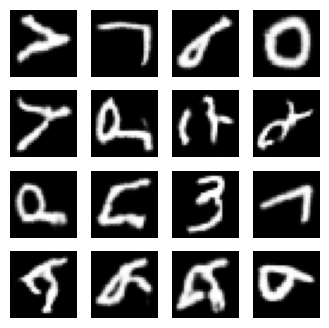

Epoch 26/50 - Gen Loss: 1.0420 - Disc Loss: 1.1788 - Time: 59.35 sec
Epoch 27/50 - Gen Loss: 1.0424 - Disc Loss: 1.1797 - Time: 64.83 sec
Epoch 28/50 - Gen Loss: 1.0394 - Disc Loss: 1.1791 - Time: 60.97 sec
Epoch 29/50 - Gen Loss: 1.0302 - Disc Loss: 1.1848 - Time: 62.12 sec
Epoch 30/50 - Gen Loss: 1.0296 - Disc Loss: 1.1856 - Time: 61.07 sec


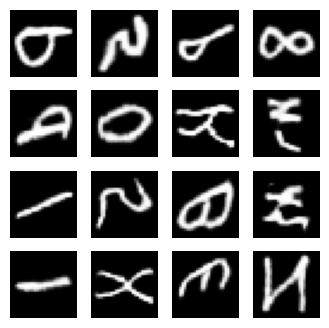

2025-09-12 21:11:45.843743: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 31/50 - Gen Loss: 1.0269 - Disc Loss: 1.1869 - Time: 59.73 sec
Epoch 32/50 - Gen Loss: 1.0217 - Disc Loss: 1.1902 - Time: 62.66 sec
Epoch 33/50 - Gen Loss: 1.0252 - Disc Loss: 1.1896 - Time: 61.08 sec
Epoch 34/50 - Gen Loss: 1.0385 - Disc Loss: 1.1918 - Time: 60.23 sec
Epoch 35/50 - Gen Loss: 1.0423 - Disc Loss: 1.1893 - Time: 61.25 sec


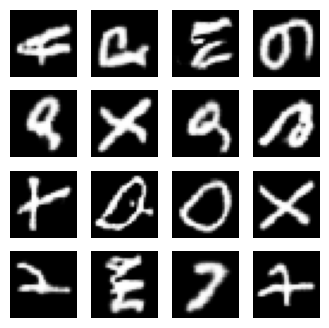

Epoch 36/50 - Gen Loss: 1.0424 - Disc Loss: 1.1910 - Time: 61.47 sec
Epoch 37/50 - Gen Loss: 1.0270 - Disc Loss: 1.1962 - Time: 61.56 sec
Epoch 38/50 - Gen Loss: 1.0236 - Disc Loss: 1.1964 - Time: 60.81 sec
Epoch 39/50 - Gen Loss: 1.0186 - Disc Loss: 1.2004 - Time: 61.55 sec
Epoch 40/50 - Gen Loss: 1.0144 - Disc Loss: 1.2023 - Time: 61.09 sec


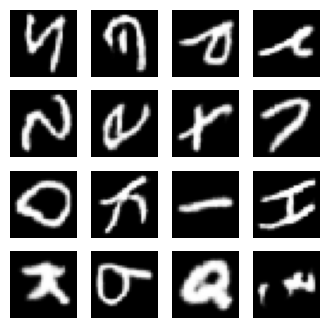

Epoch 41/50 - Gen Loss: 1.0049 - Disc Loss: 1.2065 - Time: 61.12 sec
Epoch 42/50 - Gen Loss: 1.0009 - Disc Loss: 1.2081 - Time: 60.97 sec
Epoch 43/50 - Gen Loss: 0.9901 - Disc Loss: 1.2136 - Time: 62.15 sec
Epoch 44/50 - Gen Loss: 0.9918 - Disc Loss: 1.2150 - Time: 59.74 sec
Epoch 45/50 - Gen Loss: 0.9899 - Disc Loss: 1.2171 - Time: 60.59 sec


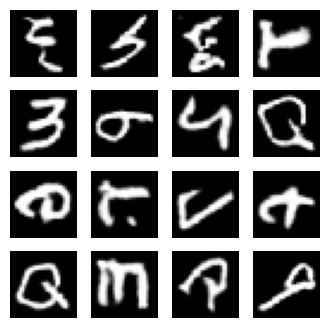

Epoch 46/50 - Gen Loss: 0.9857 - Disc Loss: 1.2200 - Time: 61.53 sec
Epoch 47/50 - Gen Loss: 0.9767 - Disc Loss: 1.2250 - Time: 60.22 sec
Epoch 48/50 - Gen Loss: 0.9634 - Disc Loss: 1.2290 - Time: 60.75 sec
Epoch 49/50 - Gen Loss: 0.9648 - Disc Loss: 1.2299 - Time: 60.10 sec
Epoch 50/50 - Gen Loss: 0.9560 - Disc Loss: 1.2328 - Time: 62.24 sec


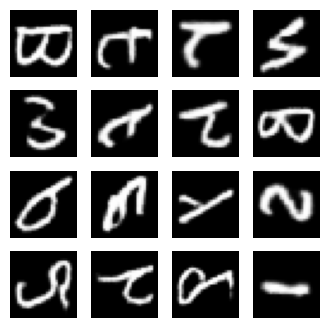

In [5]:
import time
import matplotlib.pyplot as plt
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

gen_loss_history = []
disc_loss_history = []

@tf.function
def train_step(images, labels):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)
        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)
        d_loss = discriminator_loss(real_output, fake_output)
        g_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return g_loss, d_loss

def train(dataset, epochs):
    steps_per_epoch = np.ceil(train_images.shape[0] / BATCH_SIZE)
    for epoch in range(epochs):
        start = time.time()
        total_g_loss = 0
        total_d_loss = 0
        step = 0
        for image_batch, label_batch in dataset:
            g_loss, d_loss = train_step(image_batch, label_batch)
            total_g_loss += g_loss
            total_d_loss += d_loss
            step += 1
        avg_g_loss = total_g_loss / step
        avg_d_loss = total_d_loss / step
        gen_loss_history.append(avg_g_loss.numpy())
        disc_loss_history.append(avg_d_loss.numpy())
        print(f"Epoch {epoch+1}/{epochs} - Gen Loss: {avg_g_loss:.4f} - Disc Loss: {avg_d_loss:.4f} - Time: {time.time()-start:.2f} sec")
        if (epoch + 1) % 5 == 0:
            show_generated_images(generator, num_images=16)

def show_generated_images(model, num_images=16):
    noise = tf.random.normal([num_images, LATENT_DIM])
    random_ints = tf.random.uniform([num_images], minval=0, maxval=NUM_CLASSES, dtype=tf.int32)
    random_labels = tf.one_hot(random_ints, depth=NUM_CLASSES)
    generated = model([noise, random_labels], training=False)
    generated = (generated + 1) / 2.0

    plt.figure(figsize=(4,4))
    for i in range(num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(tf.squeeze(generated[i]), cmap='gray')
        plt.axis('off')
    plt.show()

EPOCHS = 50
train(ds_train, EPOCHS)

Epoch 51/100 - Gen Loss: 0.9534 - Disc Loss: 1.2337 - Time: 60.67 sec
Epoch 52/100 - Gen Loss: 0.9524 - Disc Loss: 1.2337 - Time: 61.10 sec
Epoch 53/100 - Gen Loss: 0.9508 - Disc Loss: 1.2376 - Time: 65.15 sec
Epoch 54/100 - Gen Loss: 0.9435 - Disc Loss: 1.2379 - Time: 62.32 sec
Epoch 55/100 - Gen Loss: 0.9426 - Disc Loss: 1.2381 - Time: 59.24 sec

Generating sample images at epoch 55


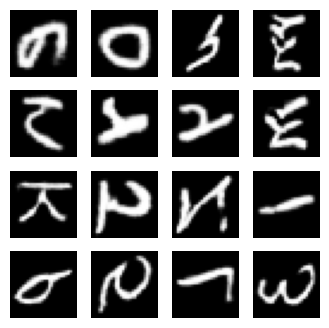

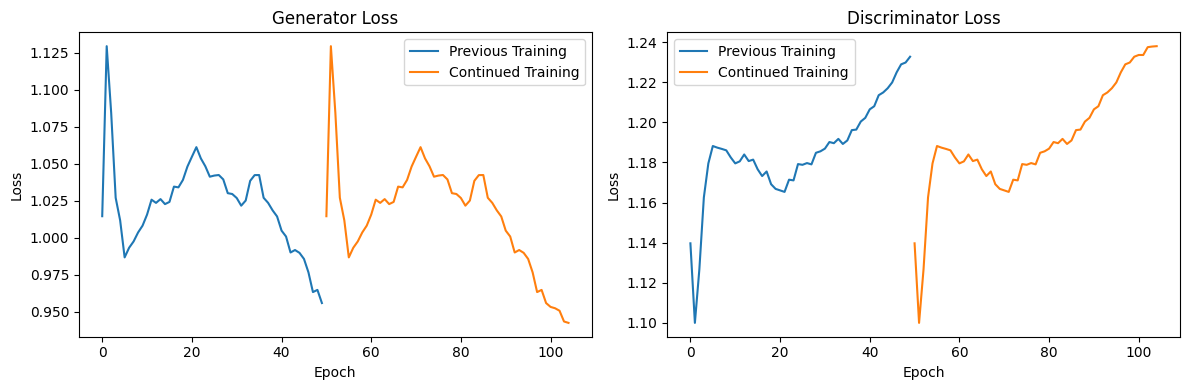

Epoch 56/100 - Gen Loss: 0.9476 - Disc Loss: 1.2385 - Time: 59.07 sec
Epoch 57/100 - Gen Loss: 0.9429 - Disc Loss: 1.2391 - Time: 59.19 sec
Epoch 58/100 - Gen Loss: 0.9371 - Disc Loss: 1.2435 - Time: 62.84 sec
Epoch 59/100 - Gen Loss: 0.9299 - Disc Loss: 1.2462 - Time: 62.00 sec
Epoch 60/100 - Gen Loss: 0.9360 - Disc Loss: 1.2413 - Time: 59.24 sec

Generating sample images at epoch 60


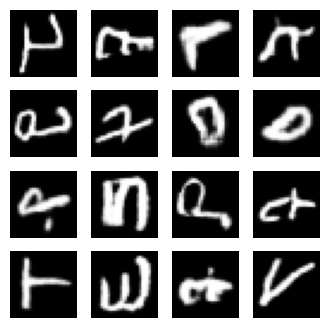

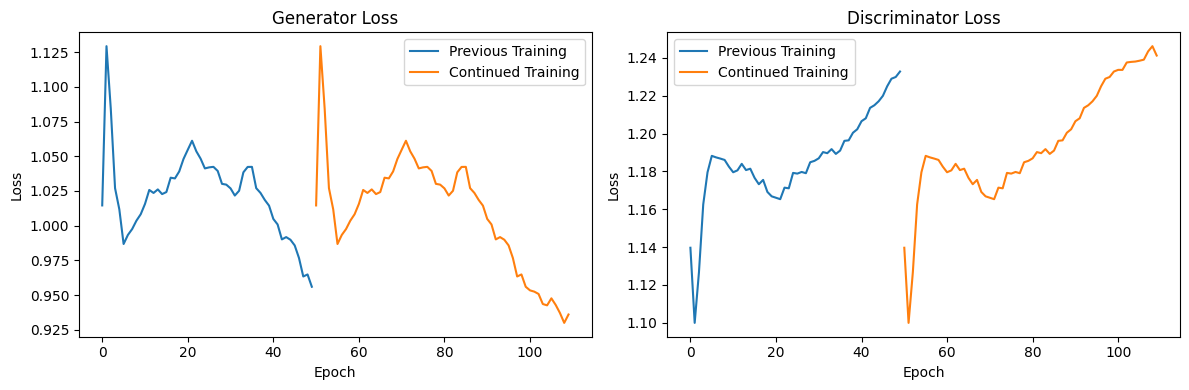

Epoch 61/100 - Gen Loss: 0.9352 - Disc Loss: 1.2423 - Time: 58.94 sec
Epoch 62/100 - Gen Loss: 0.9365 - Disc Loss: 1.2418 - Time: 58.87 sec


2025-09-12 21:46:30.357130: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 63/100 - Gen Loss: 0.9354 - Disc Loss: 1.2440 - Time: 58.22 sec
Epoch 64/100 - Gen Loss: 0.9309 - Disc Loss: 1.2475 - Time: 59.48 sec
Epoch 65/100 - Gen Loss: 0.9258 - Disc Loss: 1.2487 - Time: 59.81 sec

Generating sample images at epoch 65


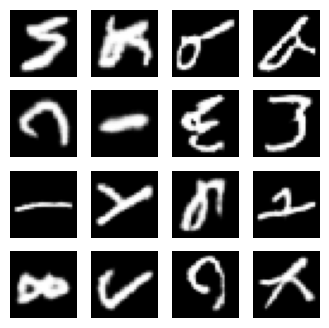

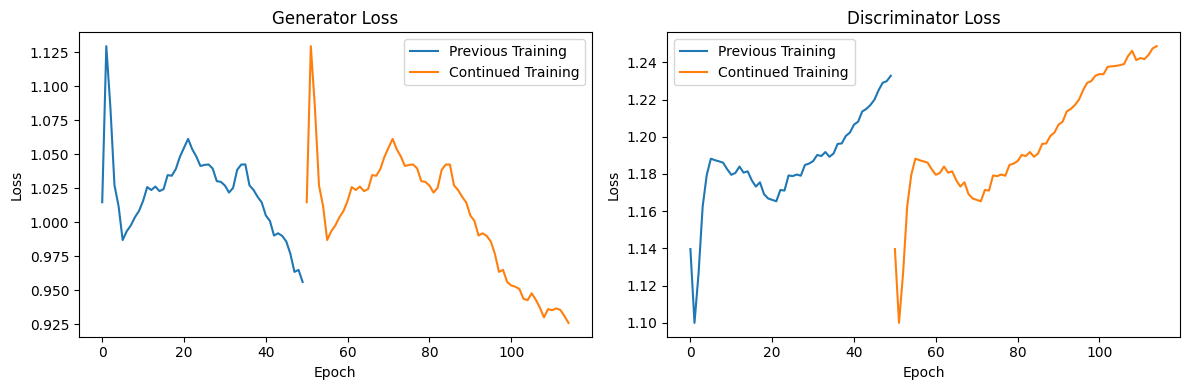

Epoch 66/100 - Gen Loss: 0.9258 - Disc Loss: 1.2484 - Time: 61.60 sec
Epoch 67/100 - Gen Loss: 0.9243 - Disc Loss: 1.2490 - Time: 64.11 sec
Epoch 68/100 - Gen Loss: 0.9244 - Disc Loss: 1.2493 - Time: 64.35 sec
Epoch 69/100 - Gen Loss: 0.9269 - Disc Loss: 1.2475 - Time: 62.68 sec
Epoch 70/100 - Gen Loss: 0.9220 - Disc Loss: 1.2505 - Time: 60.64 sec

Generating sample images at epoch 70


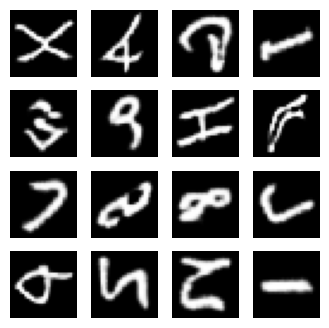

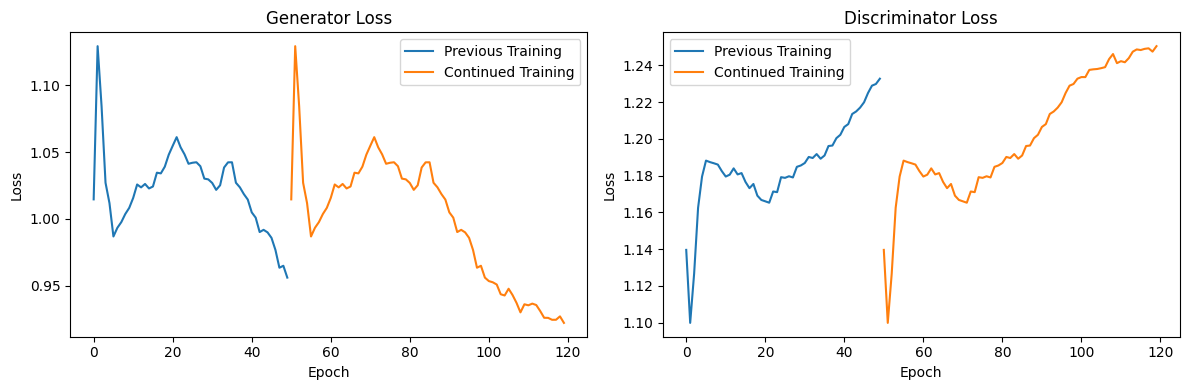

Epoch 71/100 - Gen Loss: 0.9198 - Disc Loss: 1.2513 - Time: 63.52 sec
Epoch 72/100 - Gen Loss: 0.9239 - Disc Loss: 1.2503 - Time: 63.88 sec
Epoch 73/100 - Gen Loss: 0.9204 - Disc Loss: 1.2509 - Time: 61.39 sec
Epoch 74/100 - Gen Loss: 0.9248 - Disc Loss: 1.2505 - Time: 62.79 sec
Epoch 75/100 - Gen Loss: 0.9168 - Disc Loss: 1.2541 - Time: 63.47 sec

Generating sample images at epoch 75


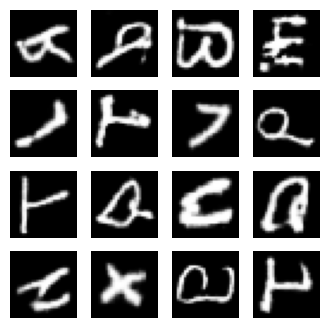

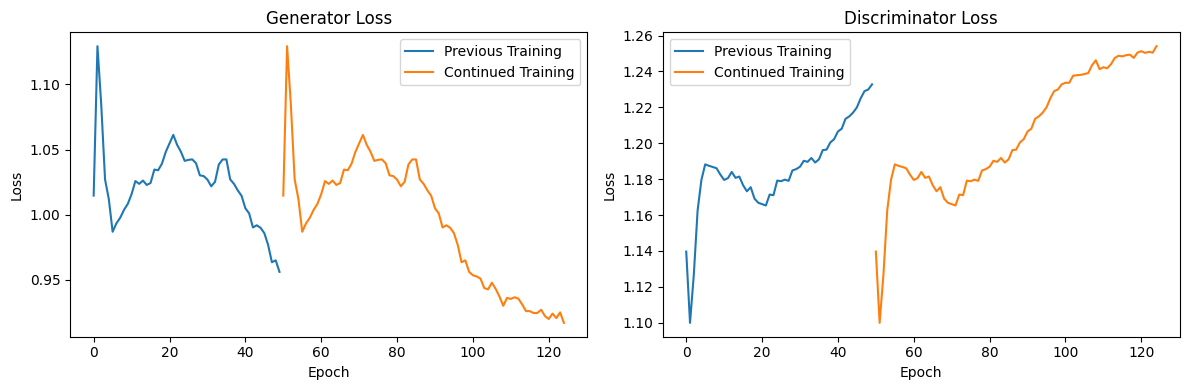

Epoch 76/100 - Gen Loss: 0.9152 - Disc Loss: 1.2560 - Time: 63.75 sec
Epoch 77/100 - Gen Loss: 0.9155 - Disc Loss: 1.2523 - Time: 60.80 sec
Epoch 78/100 - Gen Loss: 0.9099 - Disc Loss: 1.2583 - Time: 60.93 sec
Epoch 79/100 - Gen Loss: 0.9164 - Disc Loss: 1.2505 - Time: 61.40 sec
Epoch 80/100 - Gen Loss: 0.9197 - Disc Loss: 1.2547 - Time: 62.06 sec

Generating sample images at epoch 80


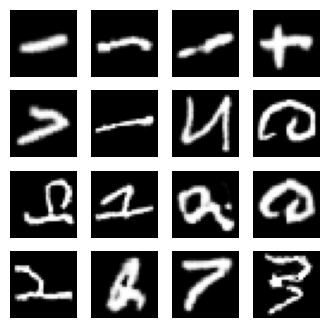

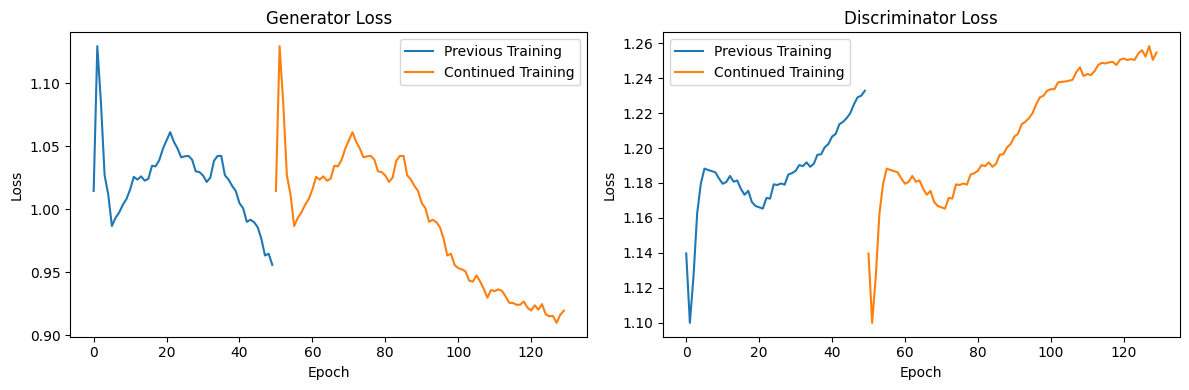

Epoch 81/100 - Gen Loss: 0.9158 - Disc Loss: 1.2526 - Time: 58.97 sec
Epoch 82/100 - Gen Loss: 0.9159 - Disc Loss: 1.2545 - Time: 60.77 sec
Epoch 83/100 - Gen Loss: 0.9157 - Disc Loss: 1.2533 - Time: 61.14 sec
Epoch 84/100 - Gen Loss: 0.9138 - Disc Loss: 1.2549 - Time: 60.15 sec
Epoch 85/100 - Gen Loss: 0.9176 - Disc Loss: 1.2487 - Time: 60.02 sec

Generating sample images at epoch 85


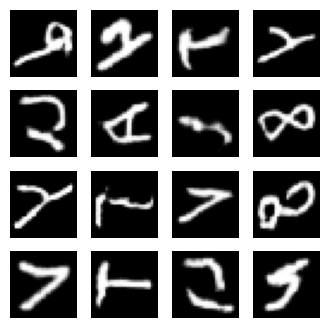

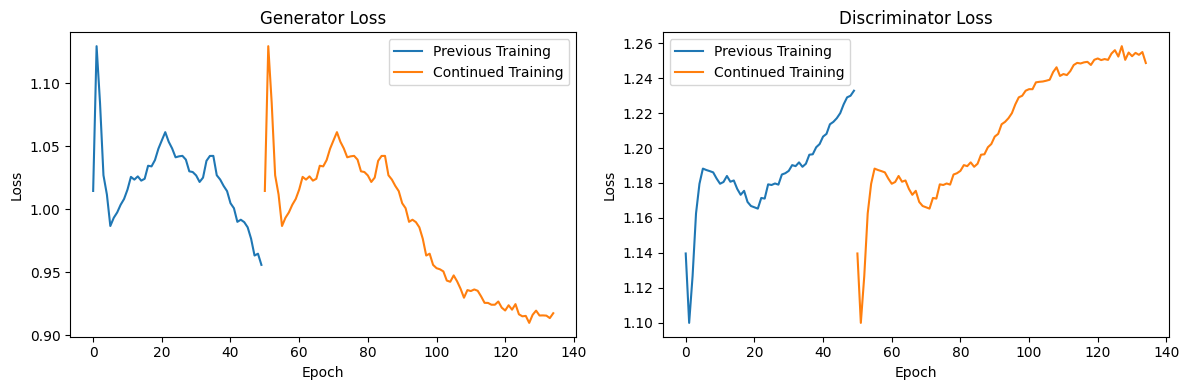

Epoch 86/100 - Gen Loss: 0.9234 - Disc Loss: 1.2506 - Time: 58.61 sec
Epoch 87/100 - Gen Loss: 0.9166 - Disc Loss: 1.2533 - Time: 58.31 sec
Epoch 88/100 - Gen Loss: 0.9196 - Disc Loss: 1.2511 - Time: 58.58 sec
Epoch 89/100 - Gen Loss: 0.9165 - Disc Loss: 1.2521 - Time: 57.91 sec
Epoch 90/100 - Gen Loss: 0.9155 - Disc Loss: 1.2519 - Time: 58.95 sec

Generating sample images at epoch 90


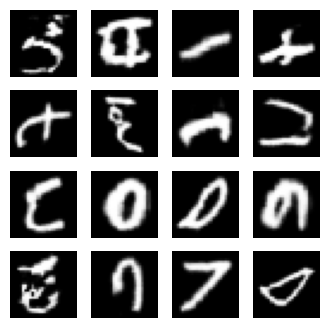

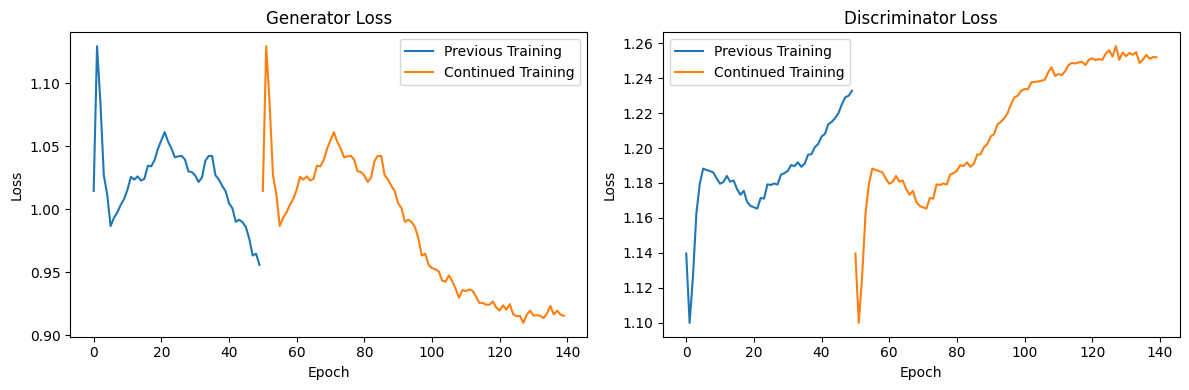

Epoch 91/100 - Gen Loss: 0.9174 - Disc Loss: 1.2538 - Time: 59.77 sec
Epoch 92/100 - Gen Loss: 0.9212 - Disc Loss: 1.2499 - Time: 58.74 sec
Epoch 93/100 - Gen Loss: 0.9195 - Disc Loss: 1.2516 - Time: 58.57 sec
Epoch 94/100 - Gen Loss: 0.9178 - Disc Loss: 1.2493 - Time: 81.91 sec
Epoch 95/100 - Gen Loss: 0.9240 - Disc Loss: 1.2457 - Time: 59.75 sec

Generating sample images at epoch 95


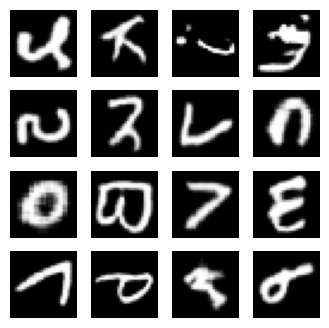

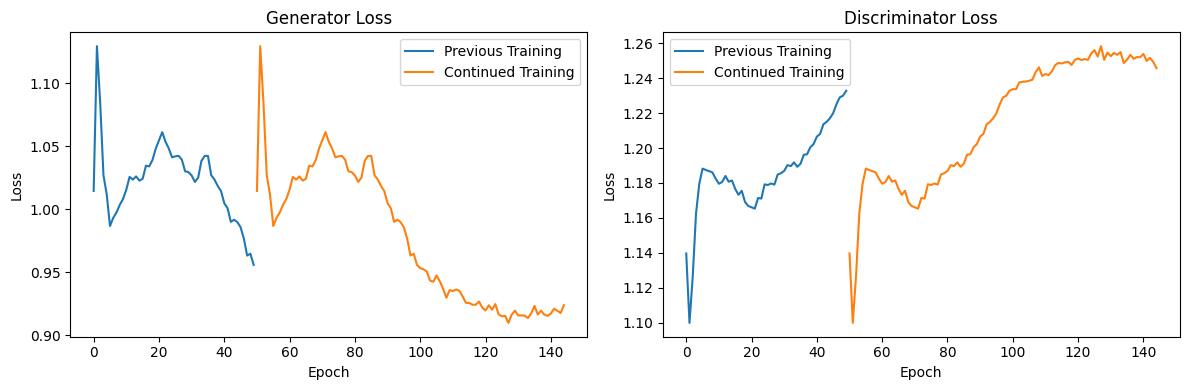

Epoch 96/100 - Gen Loss: 0.9248 - Disc Loss: 1.2485 - Time: 62.92 sec
Epoch 97/100 - Gen Loss: 0.9239 - Disc Loss: 1.2491 - Time: 66.18 sec
Epoch 98/100 - Gen Loss: 0.9215 - Disc Loss: 1.2485 - Time: 60.35 sec
Epoch 99/100 - Gen Loss: 0.9194 - Disc Loss: 1.2485 - Time: 62.85 sec
Epoch 100/100 - Gen Loss: 0.9233 - Disc Loss: 1.2466 - Time: 61.82 sec

Generating sample images at epoch 100


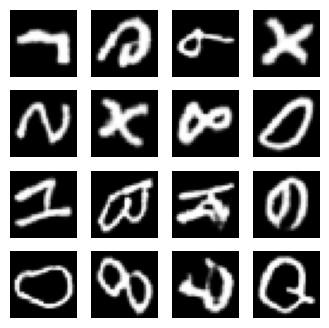

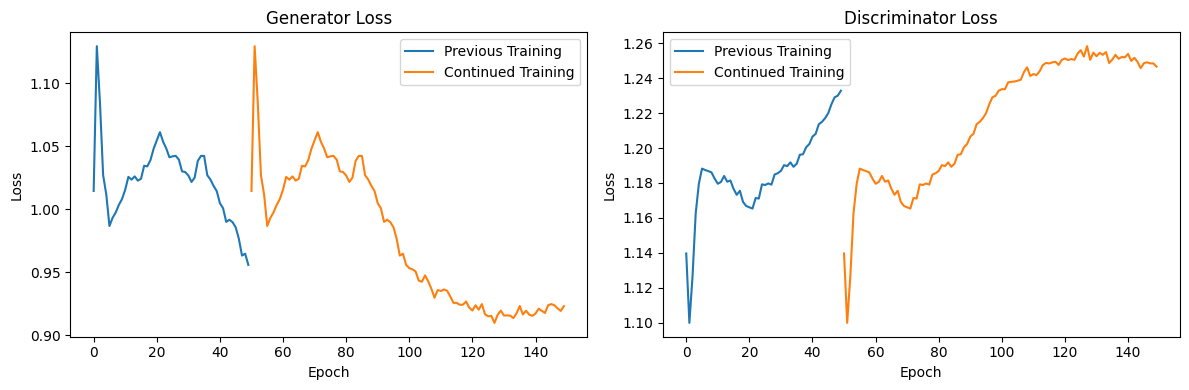


Final generated images:


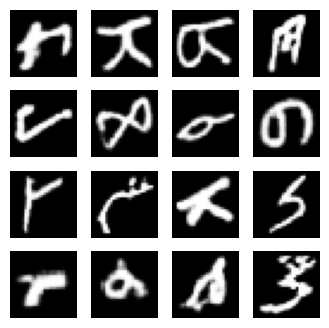

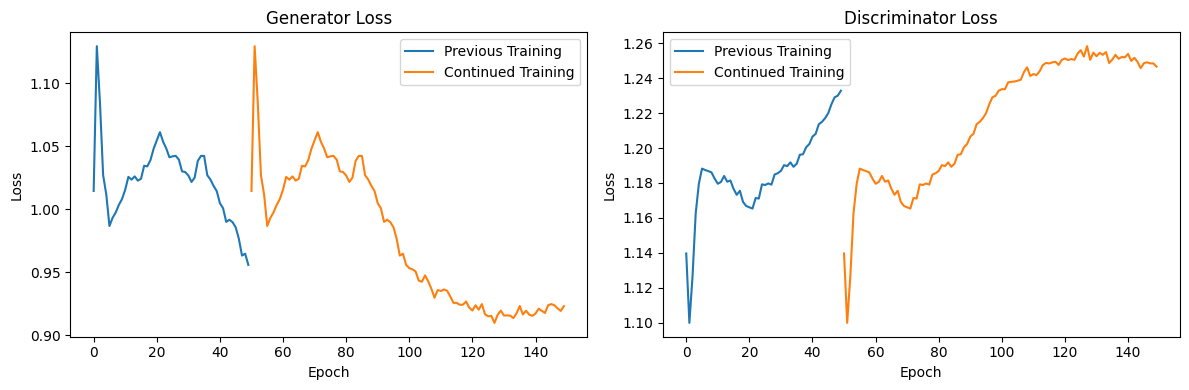

In [6]:
#Continuation of Training
previous_gen_loss = gen_loss_history.copy()
previous_disc_loss = disc_loss_history.copy()

ADDITIONAL_EPOCHS = 50
def train(dataset, epochs, start_epoch=50):
    steps_per_epoch = np.ceil(train_images.shape[0] / BATCH_SIZE)
    for epoch in range(epochs):
        start = time.time()
        total_g_loss = 0
        total_d_loss = 0
        step = 0
        
        for image_batch, label_batch in dataset:
            g_loss, d_loss = train_step(image_batch, label_batch)
            total_g_loss += g_loss
            total_d_loss += d_loss
            step += 1
            
        avg_g_loss = total_g_loss / step
        avg_d_loss = total_d_loss / step
        gen_loss_history.append(avg_g_loss.numpy())
        disc_loss_history.append(avg_d_loss.numpy())
        current_epoch = start_epoch + epoch + 1
        print(f"Epoch {current_epoch}/{start_epoch + epochs} - "
              f"Gen Loss: {avg_g_loss:.4f} - "
              f"Disc Loss: {avg_d_loss:.4f} - "
              f"Time: {time.time()-start:.2f} sec")

        if current_epoch % 5 == 0:
            print(f"\nGenerating sample images at epoch {current_epoch}")
            show_generated_images(generator, num_images=16)
            plot_loss_history(previous_gen_loss, previous_disc_loss, gen_loss_history, disc_loss_history)

def plot_loss_history(prev_gen_loss, prev_disc_loss, curr_gen_loss, curr_disc_loss):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(prev_gen_loss)), prev_gen_loss, label='Previous Training')
    plt.plot(range(len(prev_gen_loss), len(prev_gen_loss) + len(curr_gen_loss)), 
             curr_gen_loss, label='Continued Training')
    plt.title('Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(len(prev_disc_loss)), prev_disc_loss, label='Previous Training')
    plt.plot(range(len(prev_disc_loss), len(prev_disc_loss) + len(curr_disc_loss)), 
             curr_disc_loss, label='Continued Training')
    plt.title('Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

train(ds_train, ADDITIONAL_EPOCHS, start_epoch=50)
print("\nFinal generated images:")
show_generated_images(generator, num_images=16)
plot_loss_history(previous_gen_loss, previous_disc_loss, gen_loss_history, disc_loss_history)

In [9]:
# EMNIST By-Class character mapping
# This creates the mapping from characters to class indices for EMNIST byclass dataset

def create_emnist_mapping():
    """
    Creates the character mapping for EMNIST byclass dataset
    Classes 0-9: digits 0-9
    Classes 10-35: uppercase letters A-Z  
    Classes 36-61: lowercase letters a-z
    """
    mapping = {}
    reverse_mapping = {}
    
    # Digits 0-9 (classes 0-9)
    for i in range(10):
        char = str(i)
        mapping[i] = char
        reverse_mapping[char] = i
    
    # Uppercase A-Z (classes 10-35)
    for i in range(26):
        char = chr(ord('A') + i)
        class_idx = i + 10
        mapping[class_idx] = char
        reverse_mapping[char] = class_idx
    
    # Lowercase a-z (classes 36-61)
    for i in range(26):
        char = chr(ord('a') + i)
        class_idx = i + 36
        mapping[class_idx] = char
        reverse_mapping[char] = class_idx
    
    return mapping, reverse_mapping

# Create the mappings
mapping, reverse_mapping = create_emnist_mapping()

print("EMNIST Character Mapping Created!")
print(f"Total classes: {len(mapping)}")
print("Sample mappings:")
print("Digits:", {k: v for k, v in mapping.items() if k < 10})
print("Uppercase:", {k: v for k, v in mapping.items() if 10 <= k < 36})
print("Lowercase:", {k: v for k, v in mapping.items() if 36 <= k < 62})

# Verify reverse mapping
print("\nReverse mapping examples:")
print(f"'5' -> {reverse_mapping['5']}")
print(f"'A' -> {reverse_mapping['A']}")
print(f"'z' -> {reverse_mapping['z']}")

EMNIST Character Mapping Created!
Total classes: 62
Sample mappings:
Digits: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}
Uppercase: {10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}
Lowercase: {36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j', 46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't', 56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z'}

Reverse mapping examples:
'5' -> 5
'A' -> 10
'z' -> 61


Enter a digit/letter to generate (e.g., '5' or 'A' or 'b'):  8


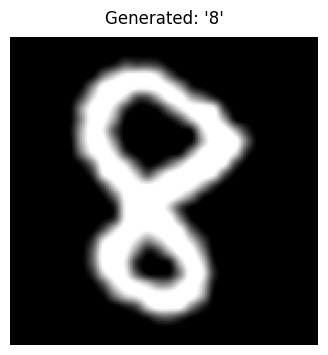

In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt

def correct_emnist_image(image_tensor, target_size=(128, 128)):
    """
    Corrects the EMNIST image orientation and improves resolution while maintaining proper size
    """
    if len(image_tensor.shape) == 2:
        image_tensor = tf.expand_dims(image_tensor, axis=-1)
    
    # First flipping left-right to correct horizontal inversion
    image = tf.image.flip_left_right(image_tensor)
    
    # Then rotating 90 degrees clockwise
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_up_down(image)
    
    # Enhancing resolution using bicubic interpolation
    enhanced_image = tf.image.resize(image, target_size, 
                                   method=tf.image.ResizeMethod.BICUBIC)
    
    # Enhancing contrast slightly to make the character more defined
    enhanced_image = tf.image.adjust_contrast(enhanced_image, 1.2)
    
    # Clipping values to ensure they stay in [0, 1] range
    enhanced_image = tf.clip_by_value(enhanced_image, 0, 1)
    
    return tf.squeeze(enhanced_image)

def generate_character(model, char, num_examples=1):
    if char not in reverse_mapping:
        print(f"Character '{char}' not in mapping. Available: {list(reverse_mapping.keys())}")
        return
    label_idx = reverse_mapping[char]
    label_vector = tf.one_hot([label_idx] * num_examples, depth=NUM_CLASSES)
    noise = tf.random.normal([num_examples, LATENT_DIM])
    generated = model([noise, label_vector], training=False)
    generated = (generated + 1) / 2.0

    for i in range(num_examples):
        plt.figure(figsize=(4, 4), dpi=100)
        corrected_image = correct_emnist_image(tf.squeeze(generated[i]))
        plt.imshow(corrected_image, cmap='gray')
        plt.title(f"Generated: '{char}'", fontsize=12, pad=10)
        plt.axis('off')
        plt.show()


user_char = input("Enter a digit/letter to generate (e.g., '5' or 'A' or 'b'): ").strip()
generate_character(generator, user_char, num_examples=1)


Enter a sentence (or 'q' to quit):  hello


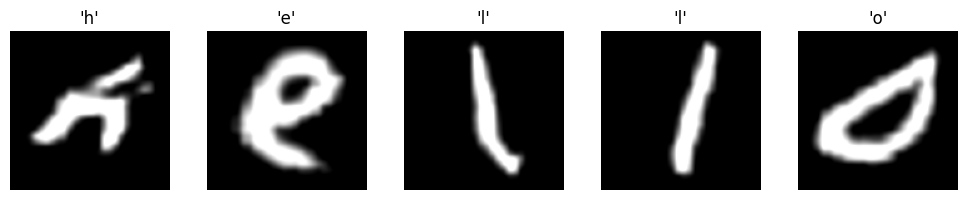


Enter a sentence (or 'q' to quit):  hello


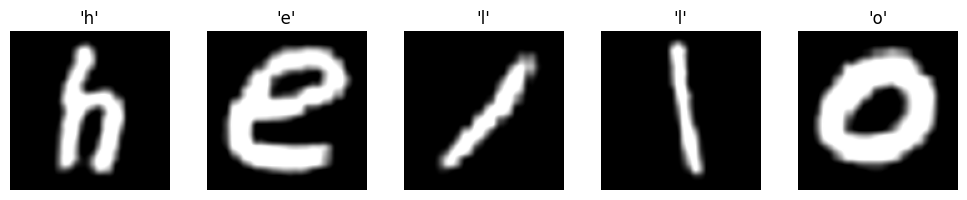


Enter a sentence (or 'q' to quit):  fucker


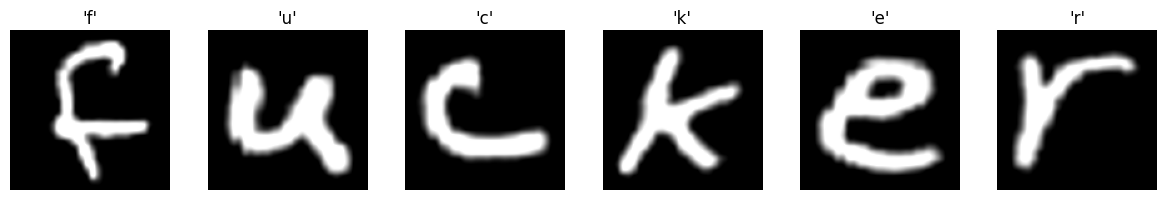


Enter a sentence (or 'q' to quit):  nigger


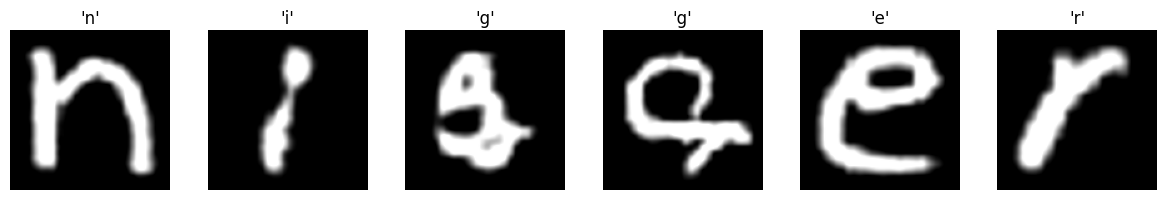


Enter a sentence (or 'q' to quit):  dengichuko


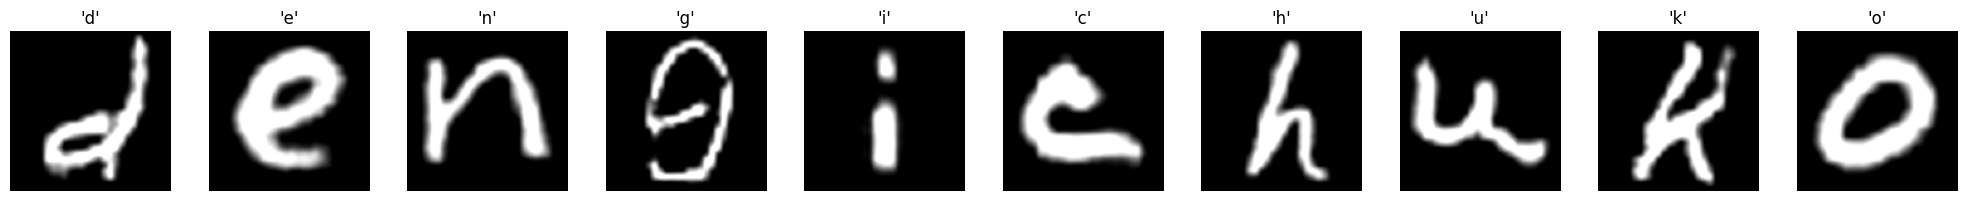


Enter a sentence (or 'q' to quit):  clanka


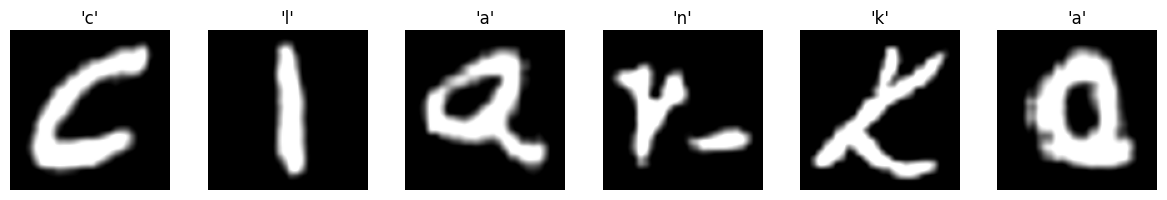


Enter a sentence (or 'q' to quit):  twink


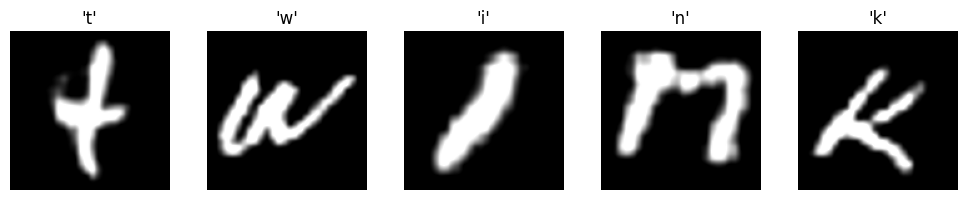


Enter a sentence (or 'q' to quit):  q


Generation complete!


In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def generate_sentence_images(model, sentence):
    """
    Generates images for each valid character in the sentence and displays them side by side
    """
    sentence = sentence.strip()
    valid_chars = []
    generated_images = []
    
    for char in sentence:
        if char.isspace():
            continue
        
        if char not in reverse_mapping:
            print(f"Warning: Character '{char}' not in mapping, skipping.")
            continue
            
        valid_chars.append(char)
        
        label_idx = reverse_mapping[char]
        label_vector = tf.one_hot([label_idx], depth=NUM_CLASSES)
        noise = tf.random.normal([1, LATENT_DIM])
        
        generated = model([noise, label_vector], training=False)
        generated = (generated + 1) / 2.0  # rescale to [0,1]
        
        corrected_image = correct_emnist_image(tf.squeeze(generated[0]))
        generated_images.append(corrected_image.numpy())
    
    if not generated_images:
        print("No valid characters to generate!")
        return
    
    num_chars = len(generated_images)
    fig_width = min(2 * num_chars, 20)
    
    plt.figure(figsize=(fig_width, 2))
    
    for idx, (char, img) in enumerate(zip(valid_chars, generated_images)):
        plt.subplot(1, num_chars, idx + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"'{char}'", pad=5)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

while True:
    user_input = input("\nEnter a sentence (or 'q' to quit): ").strip()
    
    if user_input.lower() == 'q':
        break
        
    if not user_input:
        print("Please enter some text!")
        continue
        
    generate_sentence_images(generator, user_input)

print("Generation complete!")

In [20]:
# Save the trained models for deployment
import os
import pickle

# Create a models directory
models_dir = "saved_models"
os.makedirs(models_dir, exist_ok=True)

# Save the generator model
generator.save(os.path.join(models_dir, "handwritten_generator.h5"))
print("Generator model saved to saved_models/handwritten_generator.h5")

# Save the discriminator model (optional, mainly needed generator for inference)
discriminator.save(os.path.join(models_dir, "handwritten_discriminator.h5"))
print("Discriminator model saved to saved_models/handwritten_discriminator.h5")

# Save the character mappings
mappings_data = {
    'mapping': mapping,
    'reverse_mapping': reverse_mapping,
    'NUM_CLASSES': NUM_CLASSES,
    'LATENT_DIM': LATENT_DIM
}

with open(os.path.join(models_dir, "character_mappings.pkl"), 'wb') as f:
    pickle.dump(mappings_data, f)
print("Character mappings saved to saved_models/character_mappings.pkl")

# Save training history (optional)
training_history = {
    'gen_loss_history': gen_loss_history,
    'disc_loss_history': disc_loss_history
}

with open(os.path.join(models_dir, "training_history.pkl"), 'wb') as f:
    pickle.dump(training_history, f)
print("Training history saved to saved_models/training_history.pkl")

print("\nAll models and data saved successfully!")
print("Files to transfer to Mac:")
print("- saved_models/handwritten_generator.h5")
print("- saved_models/character_mappings.pkl")
print("- saved_models/training_history.pkl (optional)")

Generator model saved to saved_models/handwritten_generator.h5
Discriminator model saved to saved_models/handwritten_discriminator.h5
Character mappings saved to saved_models/character_mappings.pkl
Training history saved to saved_models/training_history.pkl

All models and data saved successfully!
Files to transfer to Mac:
- saved_models/handwritten_generator.h5
- saved_models/character_mappings.pkl
- saved_models/training_history.pkl (optional)
